# 1. Model 구현

In [1]:
%load_ext tensorboard

In [2]:
import cv2, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\GC\\anaconda3\\envs\\sangmin_env\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [4]:
#rm -rf ./logs/

In [5]:
# Dice coefficient, IoU Metric

from tensorflow.keras import backend as K

def iou_gpu(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())
	
def dice_coef_gpu(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [6]:
import keras
from keras import models, layers


def conv_3x3_relu(x, n):
    x = layers.Conv2D(n, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)

    return x



def Unet(a, b, c, d):
    # a = input_size
    # b = 처음에 몇 채널로 시작할지
    # c = output channel의 개수.
    # d = activation function

    input = layers.Input(a)


    #Encoder

    x = conv_3x3_relu(input, b)
    down1 = conv_3x3_relu(x, b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down1)


    x = conv_3x3_relu(x, 2*b)
    down2 = conv_3x3_relu(x, 2*b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down2)


    x = conv_3x3_relu(x, 4*b)
    down3 = conv_3x3_relu(x, 4*b)
    x = layers.MaxPool2D(pool_size=(2, 2))(down3)


    x = conv_3x3_relu(x, 8*b)
    down4 = conv_3x3_relu(x, 8*b)
    drop1 = layers.Dropout(0.3)(down4)
    x = layers.MaxPool2D(pool_size=(2, 2))(drop1)




    # Bottleneck

    x = conv_3x3_relu(x, 16*b)
    x = conv_3x3_relu(x, 16*b)
    drop2 = layers.Dropout(0.3)(x)




    # Decoder

    up1 = layers.Conv2DTranspose(8*b, (2, 2), strides=(2, 2))(drop2)
    merge1 = layers.concatenate([down4, up1], axis=3)
    x = conv_3x3_relu(merge1, 8*b)
    x = conv_3x3_relu(x, 8*b)
    x = conv_3x3_relu(x, 8*b)


    up2 = layers.Conv2DTranspose(4*b, (2, 2), strides=(2, 2))(x)
    merge2 = layers.concatenate([down3, up2], axis=3)
    x = conv_3x3_relu(merge2, 4*b)
    x = conv_3x3_relu(x, 4*b) 
    x = conv_3x3_relu(x, 4*b)


    up3 = layers.Conv2DTranspose(2*b, (2, 2), strides=(2, 2))(x)
    merge3 = layers.concatenate([down2, up3], axis=3)
    x = conv_3x3_relu(merge3, 2*b)
    x = conv_3x3_relu(x, 2*b) 
    x = conv_3x3_relu(x, 2*b)


    up4 = layers.Conv2DTranspose(b, (2, 2), strides=(2, 2))(x)
    merge4 = layers.concatenate([down1, up4], axis=3)
    x = conv_3x3_relu(merge4, b)
    x = conv_3x3_relu(x, b) 

    output = layers.Conv2D(c, (1, 1),name = 'result',activation = d)(x)

    Unet_model = models.Model(inputs=input, outputs=output)


    return Unet_model

---

```# a = input_size
    # b = 처음에 몇 채널로 시작할지
    # c = output channel의 개수.
    # d = activation function```

In [7]:
model = Unet((128, 128, 3), 32, 3, 'softmax')

# 2. Data load

In [8]:
import glob

data = glob.glob('.\\Data\\Chest CT Segmentation\\image\\image\\*.jpg')
label = glob.glob('.\\Data\\Chest CT Segmentation\\masks\\masks\\*.jpg')

In [9]:
print(len(data), len(label))

16708 16708


In [10]:
def get_img(fstr):
    """
    jpg, png등의 영상을 읽어들임.
    numpy ndarray형으로 읽어들임.
    """
    img = cv2.imread(fstr)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    #img = img/255.0
    #print(img.shape, img.dtype, np.max(img))
    return img

In [11]:
train_data = []
train_label = []

val_data = []
val_label = []

test_data = []
test_label = []


for i in range(8000):
    train_x = get_img(data[i])
    train_y = get_img(label[i])

    train_y[train_y < 240] = 0  # remove artifacts
    train_y[train_y >= 240] = 255
    
    #train_x = train_x/255.0
    #train_y = train_y/255.0
    
    train_data.append(train_x)
    train_label.append(train_y)
    
    
for i in range(2000):
    val_x = get_img(data[i+8000])
    val_y = get_img(label[i+8000])
    
    val_y[val_y < 240] = 0
    val_y[val_y >= 240] = 255
    
    #val_x = val_x/255.0
    #val_y = val_y/255.0
    
    val_data.append(val_x)
    val_label.append(val_y)
    

for i in range(1000):
    test_x = get_img(data[i+10000])
    test_y = get_img(label[i+10000])
    
    test_y[test_y < 240] = 0
    test_y[test_y >= 240] = 255
    
    #test_x = test_x/255.0
    #test_y = test_y/255.0
    
    test_data.append(test_x)
    test_label.append(test_y)

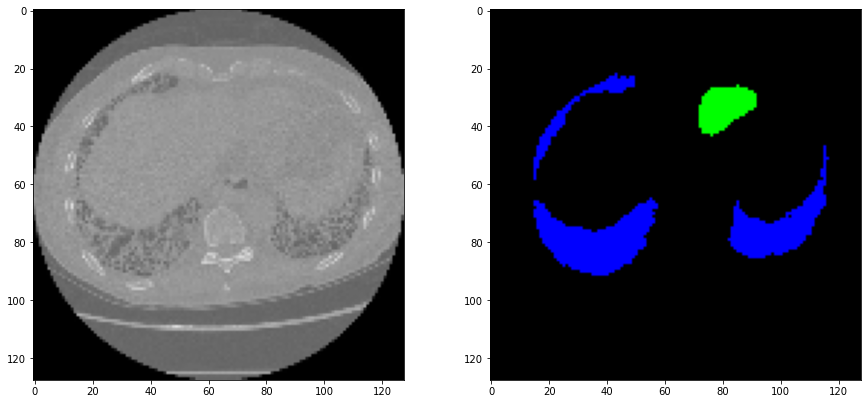

In [12]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(train_data[15])

plt.subplot(222)
plt.imshow(train_label[15])

In [13]:
np.max(train_data[15])

224

In [14]:
np.max(train_label[200])

255

In [15]:
np.min(train_label[200])

0

In [16]:
train_data = np.array(train_data)
train_label = np.array(train_label)

val_data = np.array(val_data)
val_label = np.array(val_label)

test_data = np.array(test_data)
test_label = np.array(test_label)


print(train_data.shape, train_label.shape, val_data.shape, val_label.shape, test_data.shape, test_label.shape, end='\n')

(8000, 128, 128, 3) (8000, 128, 128, 3) (2000, 128, 128, 3) (2000, 128, 128, 3) (1000, 128, 128, 3) (1000, 128, 128, 3)


In [17]:
train_data.shape

(8000, 128, 128, 3)

In [18]:
import datetime as dt

time_now = dt.datetime.now()
print(time_now.date())

2022-05-25


In [19]:
np.save(f'./Data/Chest CT Segmentation/train_x_{time_now.date()}.npy', train_data)
np.save(f'./Data/Chest CT Segmentation/train_y_{time_now.date()}.npy', train_label)

np.save(f'./Data/Chest CT Segmentation/val_x_{time_now.date()}.npy', val_data)
np.save(f'./Data/Chest CT Segmentation/val_y_{time_now.date()}.npy', val_label)

np.save(f'./Data/Chest CT Segmentation/test_x_{time_now.date()}.npy', test_data)
np.save(f'./Data/Chest CT Segmentation/test_y_{time_now.date()}.npy', test_label)

In [20]:
#model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy, metrics='val_loss')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ('accuracy', iou_gpu, dice_coef_gpu))

### model checkpoint

In [21]:
from datetime import datetime

logdir="./log/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [22]:
from tensorflow.keras.callbacks import TensorBoard

In [23]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    f'./weight/{time_now.date()}_dice_model.h5',
    monitor='val_dice_coef_gpu',
    verbose=0,
    save_best_only=True,
    save_weights_only=False
)

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

In [24]:
history = model.fit(train_data, train_label, epochs = 200, batch_size = 100 ,
                    validation_data = (val_data, val_label), 
                    callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/200
 1/80 [..............................] - ETA: 0s - loss: 32.6593 - accuracy: 0.3938 - iou_gpu: 0.3719 - dice_coef_gpu: 0.5421WARNING:tensorflow:From C:\Users\GC\anaconda3\envs\sangmin_env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
80/80 [==============================] - 20s 255ms/step - loss: 31.5770 - accuracy: 0.3569 - iou_gpu: 0.4523 - dice_coef_gpu: 0.6194 - val_loss: 29.8118 - val_accuracy: 0.4322 - val_iou_gpu: 0.4490 - val_dice_coef_gpu: 0.6180
Epoch 2/200
80/80 [==============================] - 20s 249ms/step - loss: 16.9510 - accuracy: 0.3498 - iou_gpu: 1.2394 - dice_coef_gpu: 1.0683 - val_loss: 27.2356 - val_accuracy: 0.5721 - val_iou_gpu: 0.5349 - val_dice_coef_gpu: 0.6939
Epoch 3/200
80/80 [==============================] - 20s 249ms/step - loss: 7.4302 - accuracy: 0.4062 -

## Plot

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_dice = history.history['val_dice_coef_gpu']

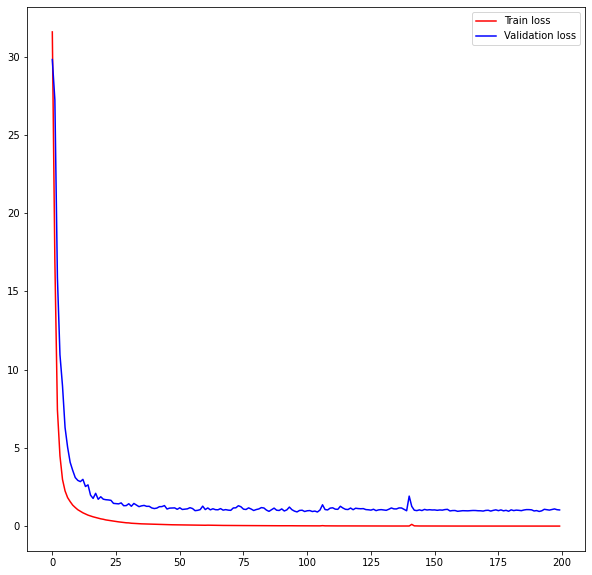

In [33]:
plt.figure(figsize = (10, 10))
#plt.ylim((0, 0.1))

plt.plot(train_loss, 'r', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')

plt.legend()

In [27]:
train_dice = history.history['dice_coef_gpu']
val_dice = history.history['val_dice_coef_gpu']

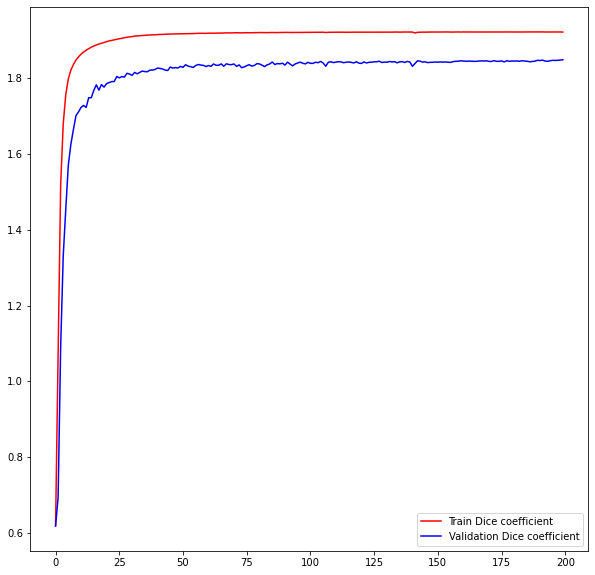

In [34]:
plt.figure(figsize = (10, 10))
#plt.ylim((0, 0.3))

plt.plot(train_dice, 'r', label='Train Dice coefficient')
plt.plot(val_dice, 'b', label='Validation Dice coefficient')

plt.legend()

---   
# Test

In [30]:
test_data.shape

(1000, 128, 128, 3)

In [31]:
# test_data, test_label

predict_result = model.predict(test_data)

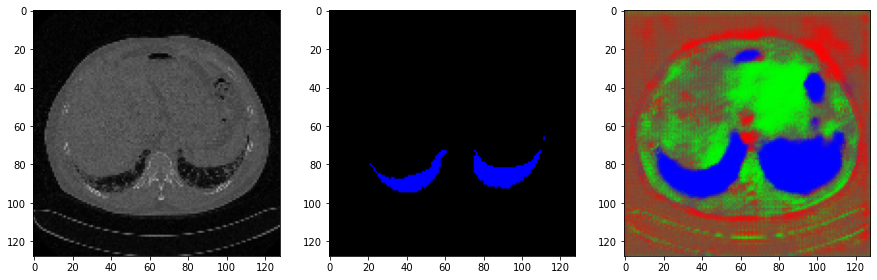

In [32]:
q = 300

plt.figure(figsize = (15, 15))

plt.subplot(231)
plt.imshow(test_data[q])

plt.subplot(232)
plt.imshow(test_label[q])

plt.subplot(233)
plt.imshow(predict_result[q])


#print(iou_gpu(test_label[q], predict_result[q]))